In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from pathlib import Path

gt1 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (1).csv')
gt2 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (2).csv')
gt3 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (3).csv')
gt4 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (4).csv')

gt = pd.concat([gt1, gt2, gt3, gt4]).drop_duplicates().reset_index(drop=True)


def to_fset(x):
    return frozenset(x) if isinstance(x, list) else frozenset()

def append_df(df: pd.DataFrame, path: str):
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)

def load_weekly_csv(file):
    """
    Load weekly profile CSV with memory-friendly dtypes.
    Adjust dtypes if your columns differ.
    """
    dtypes = {
        "agent": "int64",
        "day_type": "category",
        "time_segment": "category",
        "dominent_poi": "category",
        # chunk (week index) might exist:
        "chunk": "int16",
    }

    # numeric columns we need
    num_cols = [
        "unique_location_ids", "avg_distance_from_home_km", "avg_speed_kmh",
        "max_stay_duration", "transformations", "max_distance_from_home",
    ]

    df = file.copy()

    # cast / clean
    if "agent" in df.columns:
        df["agent"] = pd.to_numeric(df["agent"], errors="coerce").fillna(-1).astype("int64")

    for c, t in dtypes.items():
        if c in df.columns:
            try:
                df[c] = df[c].astype(t)
            except Exception:
                pass

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0).astype("float32")


    df["unique_locs_set"] = df["unique_locs"].apply(to_fset)
    df["poi_dict_set"] = df["poi_dict"].apply(to_fset)

    # keep only needed columns to cut RAM
    keep = ["agent", "day_type", "time_segment", "dominent_poi",
            "unique_locs_set", "poi_dict_set"] + num_cols
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    return df

### Results

In [ ]:
def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
    """
    Compute anomaly score for agents present in this partition.
    Rule:
      For each test row, compare to all train rows with same (agent, day_type, time_segment),
      keep min score; then agent score = max over its test rows of these mins.
    """
    if test_p.empty:
        return pd.DataFrame(columns=["agent", "anomaly_score"])

    # weights pinned as plain floats
    alpha = 0.12843882159674627
    beta = 0.1277477026006959
    gamma = 0.27669311145381176
    delta = 0.16113361696495052
    a = 0.12838810029558317
    b = 0.3045173365002024
    c = 0.760066526759694
    d = 0.12433512484214806
    e = -0.14401261257898515

    KEYS = ["agent", "day_type", "time_segment"]
    NUM = ["unique_location_ids","avg_distance_from_home_km","avg_speed_kmh",
           "max_stay_duration","transformations","max_distance_from_home"]

    test_p = test_p.reset_index(drop=True)
    test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

    pairs = test_p.merge(train_p, on=KEYS, how="inner", suffixes=("_test", "_train"))

    if pairs.empty:
        # no matching train slots -> could return inf or NaN; here: 0 so it doesn’t explode rankings
        out = test_p.groupby("agent", sort=False).size().reset_index()[["agent"]]
        out["anomaly_score"] = 0.0
        return out

    # vector numeric diffs
    score_count = (pairs["unique_location_ids_test"] - pairs["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (pairs["avg_distance_from_home_km_test"] - pairs["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (pairs["avg_speed_kmh_test"] - pairs["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (pairs["max_stay_duration_test"] - pairs["max_stay_duration_train"]).abs().to_numpy()
    transformations = (pairs["transformations_test"] - pairs["transformations_train"]).abs().to_numpy()
    max_distance    = (pairs["max_distance_from_home_test"] - pairs["max_distance_from_home_train"]).abs().to_numpy()

    dom_changed = (
        pairs["dominent_poi_test"].astype(str).to_numpy() !=
        pairs["dominent_poi_train"].astype(str).to_numpy()
    ).astype(np.float32)

    # set diffs (tight, but only on this partition’s merged pairs)
    t_loc = pairs["unique_locs_set_test"].to_list()
    r_loc = pairs["unique_locs_set_train"].to_list()
    new_locs = np.fromiter((len(t - r) for t, r in zip(t_loc, r_loc)),
                           dtype=np.float32, count=len(pairs))

    t_poi = pairs["poi_dict_set_test"].to_list()
    r_poi = pairs["poi_dict_set_train"].to_list()
    new_pois = np.fromiter((len(t - r) for t, r in zip(t_poi, r_poi)),
                           dtype=np.float32, count=len(pairs))

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dom_changed) +
        (e * new_pois)
    ).astype(np.float32)

    pairs["pair_score"] = total

    # min per test row
    min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

    # map test_row_id -> agent
    test_agents = test_p.set_index("test_row_id")["agent"]
    min_df = min_per_test.to_frame("min_score").join(test_agents, how="left")

    # max per agent
    out = min_df.groupby("agent", sort=False)["min_score"].max().reset_index()
    out.rename(columns={"min_score": "anomaly_score"}, inplace=True)

    return out


# ---------------- PARTITION DRIVER ----------------

def score_weekly_partitioned(train, test,
                             out_path: str,
                             n_parts: int = 200):
    """
    n_parts=100 means ~1% per shard. Use 200/500 if merge still heavy.
    """
    # remove old output (we append)
    if os.path.exists(out_path):
        os.remove(out_path)

    # partition id
    train["pid"] = (train["agent"].values % n_parts).astype(np.int16)
    test["pid"]  = (test["agent"].values  % n_parts).astype(np.int16)

    # process partitions
    for pid in range(n_parts):
        train_p = train[train["pid"] == pid].drop(columns=["pid"])
        test_p  = test[test["pid"] == pid].drop(columns=["pid"])

        if test_p.empty:
            continue

        print(f"Partition {pid}/{n_parts-1}: train_rows={len(train_p):,} test_rows={len(test_p):,}")

        out = score_partition(train_p, test_p)
        append_df(out, out_path)

        # free per-partition temp
        del train_p, test_p, out
        gc.collect()

    print("Done. Saved:", out_path)

In [3]:
month1_test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/monthly/month1_test/agent_bucket=0.csv')
month2_test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/monthly/month2_test/agent_bucket=0.csv')
month1_train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/monthly/month1_train/agent_bucket=0.csv')
month2_train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/monthly/month2_train/agent_bucket=0.csv')

In [4]:
trains = [month1_train, month2_train]
tests = [month1_test, month2_test]

train = pd.concat(trains, ignore_index=True)
test = pd.concat(tests, ignore_index=True)

train = load_weekly_csv(train)
test  = load_weekly_csv(test)

In [5]:
score_weekly_partitioned(train, test, '../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

Partition 0/199: train_rows=1,056 test_rows=1,056
Partition 1/199: train_rows=1,032 test_rows=1,032
Partition 2/199: train_rows=1,056 test_rows=1,056
Partition 3/199: train_rows=1,176 test_rows=1,176
Partition 4/199: train_rows=1,056 test_rows=1,056
Partition 5/199: train_rows=1,200 test_rows=1,200
Partition 6/199: train_rows=1,056 test_rows=1,056
Partition 7/199: train_rows=1,080 test_rows=1,080
Partition 8/199: train_rows=1,176 test_rows=1,176
Partition 9/199: train_rows=792 test_rows=792
Partition 10/199: train_rows=1,008 test_rows=1,008
Partition 11/199: train_rows=960 test_rows=960
Partition 12/199: train_rows=1,104 test_rows=1,104
Partition 13/199: train_rows=1,224 test_rows=1,224
Partition 14/199: train_rows=1,128 test_rows=1,128
Partition 15/199: train_rows=744 test_rows=744
Partition 16/199: train_rows=936 test_rows=936
Partition 17/199: train_rows=960 test_rows=960
Partition 18/199: train_rows=1,320 test_rows=1,320
Partition 19/199: train_rows=1,008 test_rows=1,008
Partition 

In [6]:
res = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/Sim1_Trial5_Agent_Classification.csv', low_memory=False)
res = res[(res['past_classification'] == 'residents') & (res['future_classification'] == 'residents')]

anomaly_df = pd.read_csv('../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

anomaly_df = anomaly_df[anomaly_df['agent'].isin(res['agent'].values)]
gt_anomaly_agents = set(gt['agent'].values)
anomaly_df['is_anomaly'] = 0
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

In [7]:
anomaly_df.sort_values(by = 'anomaly_score', ascending=False).head(60)

,agent,anomaly_score,is_anomaly
8517,1505192,51.916656,1
871,1633619,47.063690,1
3,98000,46.776787,1
259,1505805,44.481754,1
6771,1919752,42.948757,1
4165,1054895,42.344370,1
3370,6277,42.007267,1
5418,208723,40.412056,1
3615,980682,40.294697,1
915,1865020,40.151615,1


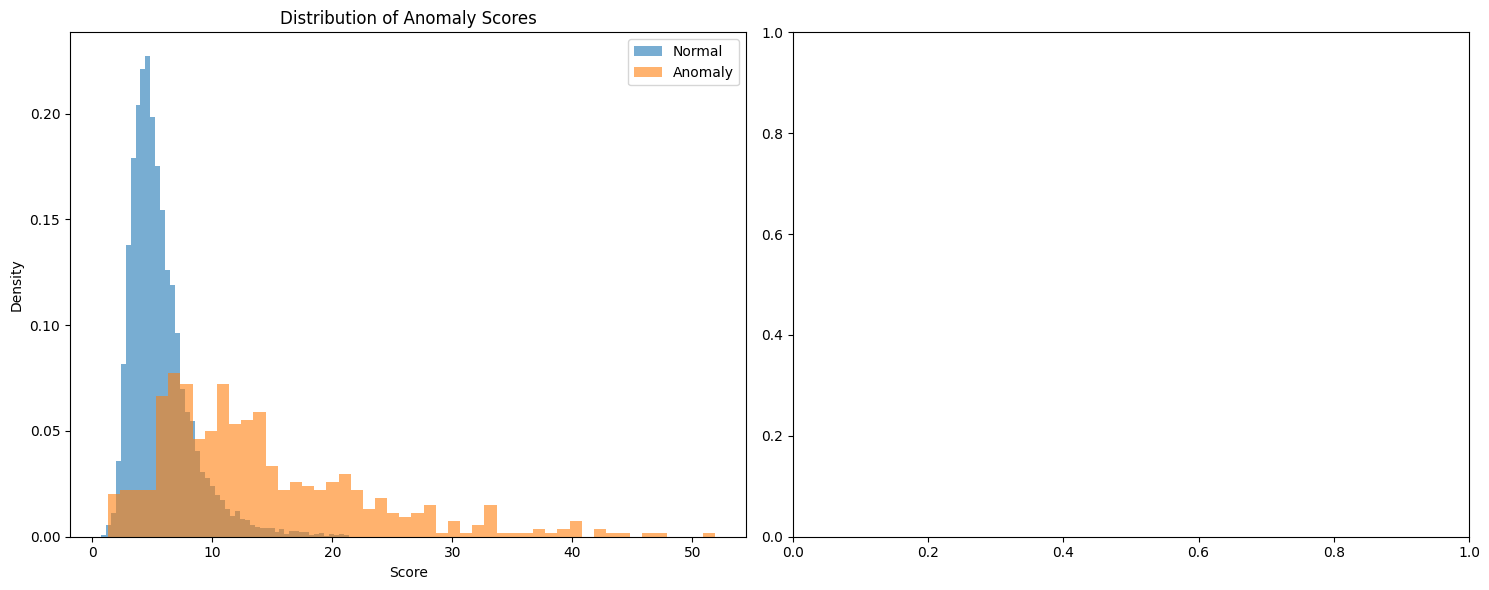

In [8]:
import matplotlib.pyplot as plt

# Data Prep
normal_scores  = anomaly_df[anomaly_df["is_anomaly"] == 0]["anomaly_score"]
anomaly_scores = anomaly_df[anomaly_df["is_anomaly"] == 1]["anomaly_score"]
#diff_normal    = anomaly_df[anomaly_df["is_anomaly"] == 0]["abs_duration_diff"]
#diff_anomaly   = anomaly_df[anomaly_df["is_anomaly"] == 1]["abs_duration_diff"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: Anomaly Scores
ax1.hist(normal_scores, bins=50, alpha=0.6, label="Normal", density=True)
ax1.hist(anomaly_scores, bins=50, alpha=0.6, label="Anomaly", density=True)
ax1.set_title("Distribution of Anomaly Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Density")
ax1.legend()

# # Right Plot: Duration Diff (Split by Label)
# ax2.hist(diff_normal, bins=50, alpha=0.6, label="Normal", density=True)
# ax2.hist(diff_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True)
# ax2.set_title("Distribution of Duration Shift")
# ax2.set_xlabel("abs_duration_diff (minutes)")
# ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # Split normal and anomaly
# normal = merged[merged["is_anomaly"] == 0]
# anomaly = merged[merged["is_anomaly"] == 1]

# # Keep only 30% of normal (i.e., drop 70%)
# normal_downsampled = normal.sample(frac=0.01, random_state=42)

# # Recombine
# merged_new = pd.concat([normal_downsampled, anomaly], ignore_index=True)

# # Shuffle so labels are mixed
# merged_new = merged_new.sample(frac=1, random_state=42).reset_index(drop=True)
# merged = merged_new

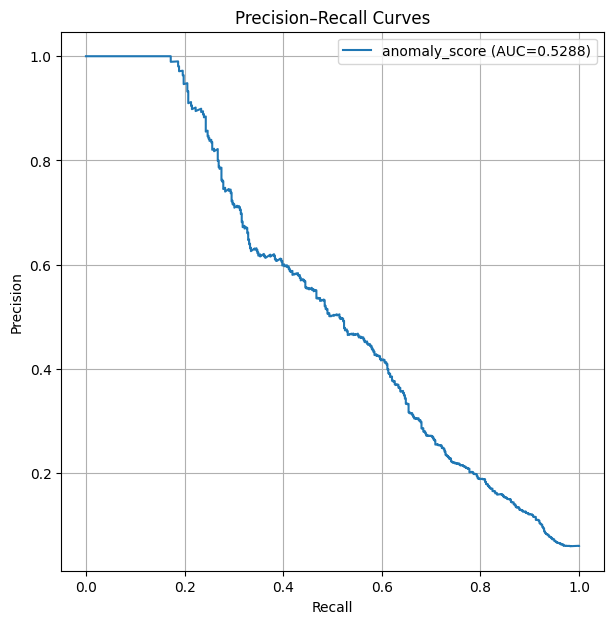

In [10]:
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()